In [1]:
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [2]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

In [3]:
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(self, x, sample_gumbel, temperature, param):
        """Gumbel-softmax trick that given a list of values of N (neigbours),
        outputs whether every item in the list is accepted or not
        """
        logits_input = 1-(1-param)**x
        logits = torch.stack((torch.log(1-logits_input), torch.log(logits_input))).reshape(2,x.size()[1])
        softmax_input = logits + sample_gumbel
        z = F.softmax(softmax_input / temperature, dim=0)
        y_pred = z.argmax(dim=0)
        return y_pred.type(torch.FloatTensor)

    @staticmethod
    def backward(ctx, grad_output):
        """"Straight through estimator
        """
        return None, None, None, F.hardtanh(grad_output)
        #return None, None, None, torch.tan(grad_output)  # <- return the identity function

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.a = nn.Parameter(torch.tensor([0.5]), requires_grad=True)  #initializing param 'a'

    def forward(self, x, sample_gumbel, temperature):
        x = STEFunction.apply(x, sample_gumbel, temperature,self.a)
        return x

In [4]:
##CREATION OF THE DATA


def sum_neighbours(x,y,grid):
    """Given a matrix and a point x,y
     outputs the number of infected neighbours of x,y
    """
    N = 0
    for i in (-1, 0 ,1):
        for j in (-1,0,1):
            if i!=0 or j!=0:
                N+= grid[x+i,y+j]
    return N

def accept_infection(x,y,grid_old, grid_new,N,beta):
    """By construction of the S.I. model, this function, given an "healthy" pixel, and
    the numbers N of infected neighbours, updates the state of that healthy pixel drawing a
    bernoulli distributed random variable with parameter 1-(1-beta)^N.
    """
    if grid_old[x,y] == 0:
        param = 1-(1-beta)**N
        grid_new[x,y] = torch.distributions.bernoulli.Bernoulli(param).sample(torch.tensor([1]))
    return 0

import numpy as np

def one_simulation(k, grid_new):
    #Simulate for k time steps
    output = []
    for m in range(0,k):
        grid_old = grid_new.clone().detach()
        for i in range(1,n-1):
            for j in range(1,n-1):
                N = sum_neighbours(i,j,grid_old)
                accept_infection(i,j,grid_old,grid_new, N,beta)
        output.append(grid_new.clone())
        if m%10 == 0:
            print(m/10)
    return torch.stack(output, dim=0)


def healthy_neighbours(grid):
    """given the matrix, this function outputs the coordinates of the healthy pixels
    (only those who can be infected) and the respective number of neighbouts
    """

    n=grid.size()[0]
    output = []
    for x in range(1,n-1):
        for y in range(1,n-1):
            if grid[x,y] ==0:
                N = 0
                for m in (-1, 0 ,1):
                    for q in (-1,0,1):
                        if n!=0 or q!=0:
                            N+= grid[m+x,q+y]
                if N>0:
                    output.append(((x,y),N.item()))
    return output

In [5]:
#set true beta
beta = 0.222222222

#THIS TAKES A WHILE

#generate a simulation where population is n x n and goes up until time step tau
#always start with an only infected pixel in the middle
n = 100
grid_size = (n,n)
grid = torch.zeros(grid_size, dtype=torch.int8)
grid[int(n/2),int(n/2)] = 1
tau = 50
res = one_simulation(tau,grid) #has size tau, n, n

0.0
1.0
2.0
3.0
4.0


In [6]:
#ouputs the total infected per time step
summed = torch.sum(res, axis=(1,2))
summed

tensor([   2,    6,   14,   23,   41,   56,   75,   96,  123,  154,  180,  223,
         266,  305,  342,  393,  445,  512,  576,  637,  701,  770,  844,  918,
         997, 1080, 1159, 1252, 1351, 1454, 1556, 1677, 1799, 1919, 2036, 2162,
        2301, 2434, 2569, 2709, 2854, 3004, 3149, 3305, 3463, 3630, 3796, 3951,
        4120, 4321])

In [7]:


#apply the healthy_neighbours function for every time step and append all the outputs
merged_list = [torch.tensor([[item[1] for item in neighbours]]).float() for neighbours in [healthy_neighbours(res[i]) for i in range(tau)]]


In [8]:
#transform everything in a tensor in order to create my final training data
merged_tensor = torch.empty(1)
for i in range(tau-1):
    merged_tensor = torch.hstack((merged_tensor, merged_list[i][0]))
merged_tensor = torch.unsqueeze(merged_tensor, dim = 0) #reshape
merged_tensor.size()

torch.Size([1, 9973])

In [11]:
model = MyModel()
optimizer = optim.SGD(model.parameters(), lr=0.005)
epochs = 1000
for epoch in range(epochs):
    #I think it's also fair to sample the stochastic process outside the loop, would surely be faster
    gumbel_sample = sample_gumbel((2,merged_tensor.size()[1]))

    y_pred= model(x = merged_tensor, sample_gumbel = gumbel_sample, temperature = 0.1)
    loss = (y_pred.mean()-summed[tau-1]/merged_tensor.size()[1])**2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

print(model.a.item())

Epoch [100/1000], Loss: 0.012679672800004482
Epoch [200/1000], Loss: 0.0007438505999743938
Epoch [300/1000], Loss: 0.00010054234735434875
Epoch [400/1000], Loss: 1.6991742768368567e-06
Epoch [500/1000], Loss: 5.791279363620561e-06
Epoch [600/1000], Loss: 1.6086488585642655e-07
Epoch [700/1000], Loss: 7.882546924520284e-06
Epoch [800/1000], Loss: 1.690123463049531e-05
Epoch [900/1000], Loss: 6.434691022150218e-05
Epoch [1000/1000], Loss: 3.382253635209054e-05
0.22370506823062897


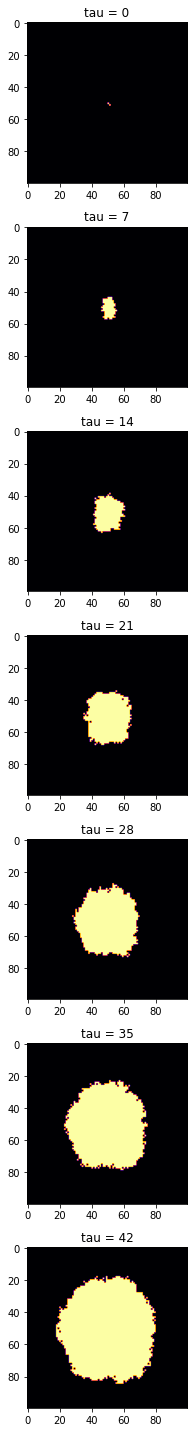

In [10]:

## PLOT
how_many_subplots = 7
show_this_ = torch.empty((7,n,n))
for i in range(7):
    show_this_[i] = res[i*int(tau/how_many_subplots)]
show_this_.size()

import matplotlib.pyplot as plt

# Assuming matrix_list is your list of matrices
# Assuming each matrix has the same dimensions

# Set up the figure and axis
fig, axs = plt.subplots(how_many_subplots, 1, figsize=(8, 20))

# Plot each matrix
for i, matrix in enumerate(show_this_):
    axs[i].imshow(matrix, cmap='inferno')  # You can change the colormap as needed
    axs[i].set_title(f'tau = {i*int(tau/how_many_subplots)}')  # Set a title for each subplot

# Adjust layout
plt.tight_layout()
plt.show()